In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

Ep 1/50, Total Reward: 30.9
Ep 2/50, Total Reward: 26.3
Ep 3/50, Total Reward: 32.4
Ep 4/50, Total Reward: 44.7
Ep 5/50, Total Reward: 23.5
Ep 6/50, Total Reward: 31.3
Ep 7/50, Total Reward: 30.0
Ep 8/50, Total Reward: 48.9
Ep 9/50, Total Reward: 33.3
Ep 10/50, Total Reward: 35.6
Ep 11/50, Total Reward: 37.1
Ep 12/50, Total Reward: 36.5
Ep 13/50, Total Reward: 36.9
Ep 14/50, Total Reward: 29.1
Ep 15/50, Total Reward: 42.8
Ep 16/50, Total Reward: 35.6
Ep 17/50, Total Reward: 14.5
Ep 18/50, Total Reward: 25.8
Ep 19/50, Total Reward: 24.1
Ep 20/50, Total Reward: 18.7
Ep 21/50, Total Reward: 27.5
Ep 22/50, Total Reward: 25.2
Ep 23/50, Total Reward: 28.9
Ep 24/50, Total Reward: 28.0
Ep 25/50, Total Reward: 25.8
Ep 26/50, Total Reward: 24.8
Ep 27/50, Total Reward: 26.5
Ep 28/50, Total Reward: 30.3
Ep 29/50, Total Reward: 33.4
Ep 30/50, Total Reward: 24.4
Ep 31/50, Total Reward: 26.6
Ep 32/50, Total Reward: 23.3
Ep 33/50, Total Reward: 40.5
Ep 34/50, Total Reward: 27.4
Ep 35/50, Total Reward:

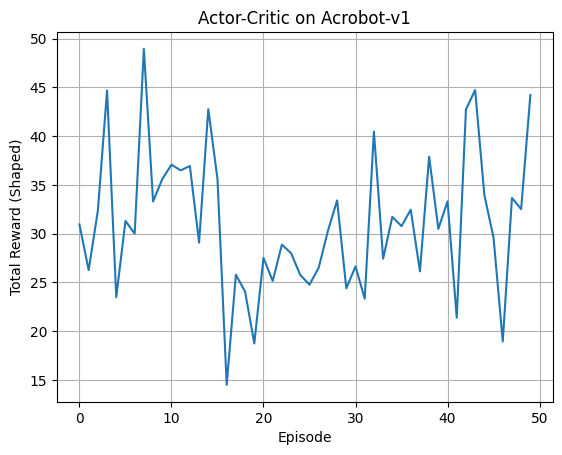

In [2]:
# Hyperparameters
EPISODES = 50
MAX_STEPS = 200
GAMMA = 0.99
LR = 0.001
ENTROPY_BETA = 0.01

# Environment
env = gym.make("Acrobot-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Actor-Critic model
class ActorCritic(nn.Module):
    def __init__(self):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU()
        )
        self.policy = nn.Sequential(
            nn.Linear(128, action_dim),
            nn.Softmax(dim=-1)
        )
        self.value = nn.Linear(128, 1)

    def forward(self, x):
        x = self.shared(x)
        return self.policy(x), self.value(x)

# Instantiate model and optimizer
model = ActorCritic()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Training loop
all_rewards = []

for episode in range(EPISODES):
    state, _ = env.reset()
    log_probs = []
    values = []
    rewards = []
    entropies = []
    total_reward = 0

    for _ in range(MAX_STEPS):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        probs, value = model(state_tensor)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()

        next_state, reward, terminated, truncated, _ = env.step(action.item())
        done = terminated or truncated

        # Reward shaping: encourage upright posture
        reward += 1.0 * (abs(state[0]) + abs(state[1]))

        log_probs.append(log_prob)
        values.append(value)
        rewards.append(reward)
        entropies.append(entropy)
        total_reward += reward

        state = next_state
        if done:
            break

    # Compute returns and advantage
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + GAMMA * R
        returns.insert(0, R)
    returns = torch.FloatTensor(returns)
    values = torch.cat(values)
    log_probs = torch.stack(log_probs)
    entropies = torch.stack(entropies)
    advantage = returns - values.squeeze()

    # Loss calculation
    actor_loss = -(log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()
    entropy_loss = -ENTROPY_BETA * entropies.mean()
    loss = actor_loss + 0.5 * critic_loss + entropy_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    all_rewards.append(total_reward)
    print(f"Ep {episode+1}/{EPISODES}, Total Reward: {total_reward:.1f}")

# Plot results
plt.plot(all_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward (Shaped)")
plt.title("Actor-Critic on Acrobot-v1")
plt.grid(True)
plt.show()
